### Import Data

In [2]:
#globo user data
import pandas as pd
#article content embedding : np matrix 364047 articles / 250D
#embeddings can be used by Neural Networks to represent their content
items2vec = pd.read_pickle(r'data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle')
#metadata info about 364047 articles
items = pd.read_csv('data/news-portal-user-interactions-by-globocom/articles_metadata.csv', delimiter = ',')
#all_click
for i in range(365):
    temp=pd.read_csv('data/news-portal-user-interactions-by-globocom/clicks/clicks/clicks_hour_'+"%03d" % i+'.csv', delimiter = ',')
    if i==0:
        clics=temp
    else:
        clics=pd.concat([clics, temp])
clics=clics.reset_index(drop=True)

In [3]:
def cut_data_by_qtime(qtime=0.5):
    '''le problème principal est que la liste d articles étaient presque complètes avant la première interaction
        en cutant par un quantile du click_timestamp, on diminuer le nombre de clics mais pas le nombre d'articles
        et si on cut par un quantile items.created_at_ts, on aura plus d interactions
        
        dans l ideal il faut cutter les items par un quantile items.created_at_ts
                                et les interactions par un quantile click_timestamp
                                en virant toutes les interactions avec des items cuttés
                                mais on peut renconter un grand saut dans le nombre d interactions'''

    cut_click=clics.click_timestamp.quantile(qtime)
    #cut_items=items.created_at_ts.quantile(q)
    #fusion items et items2vec "embedding"
    items_=pd.concat([items,pd.DataFrame(items2vec)], axis=1)
    #data cut
    clics__=clics.loc[clics.click_timestamp<cut_click].copy()
    items__=items_.loc[items_.created_at_ts<cut_click].copy()
    
    #merge clics & items, pour retirer les articles non connus
    data=clics__.loc[clics__.click_article_id.isin(set(items__.article_id))].copy()
    data.rename(columns={'click_article_id':'article_id'}, inplace = True)
    #display(data)
    #1 ligne par item interagi pour chaque user
    data_map=data[['user_id','article_id']].groupby(['user_id', 'article_id']).size().to_frame().reset_index()
    data_map.columns=['user_id','article_id','nb']
    #display(data_map)
    #extraction item2vec
    items2vec_=items__.iloc[:,5:].to_numpy()
    #creation des dicos inner_id/raw_id et raw_id/inner_id
    dico_inner_raw_iid = dict( (inner_iid,iid) for inner_iid,iid in enumerate(items__.article_id ))
    dico_raw_inner_iid = dict( (iid,inner_iid) for inner_iid,iid in enumerate(items__.article_id ))
    return data_map, items__, items2vec_, dico_inner_raw_iid, dico_raw_inner_iid

data_map,items_df, i2vec, dic_ir, dic_ri=cut_data_by_qtime(qtime=0.05)

In [4]:
print(data_map.shape)
print(i2vec.shape)
print(len(dic_ir))

(27924, 3)
(244854, 250)
244854


### Surprise Collaborative Filtering

#### Approche memory base
attention les matrices de similarité uid/uid peuvent etre tres lourdes bloquer le calcul par saturation
exemple une matrice 82000/82000 prend deja 50G
il faudrait 12000 uid pour ne pas depasser le Giga

In [5]:
from surprise import Reader, Dataset, KNNWithMeans, KNNWithZScore, SVD, SVDpp, CoClustering
from surprise.model_selection import GridSearchCV
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(data_map, reader)

In [6]:
# mesure de similarité: msd et cosine
#user based & item_based
    #probleme bloquant de memoire: user_based et cosine
    #probleme non bloquant de lenteur user_based
sim_options = {
    "name": ["msd","cosine"],#default MSD , on peut utiliser cosine
    #"min_support": [1,2],#, 2, 3, 4, 5], #The minimum number of common items/users
    "user_based": [True,False]}
param_grid = {"sim_options": sim_options}
gs_KNN_M = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=5)
gs_KNN_M.fit(data)

print(gs_KNN_M.best_score["rmse"])
print(gs_KNN_M.best_params["rmse"])
#gs_KNN_M.cv_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [7]:
# mesure de similarité: msd et cosine
#user based & item_based
    #probleme bloquant de memoire: user_based et cosine
    #probleme non bloquant de lenter user_based
sim_options = {
    "name": ["msd","cosine"],#default MSD
    #"min_support": [1,2],#, 2, 3, 4, 5], #The minimum number of common items/users
    "user_based": [True,False],
}
param_grid = {"sim_options": sim_options}
gs_KNN_Z = GridSearchCV(KNNWithZScore, param_grid, measures=["rmse"], cv=5)
gs_KNN_Z.fit(data)

print(gs_KNN_Z.best_score["rmse"])
print(gs_KNN_Z.best_params["rmse"])
#gs_KNN_Z.cv_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


#### Approche Model Based

In [8]:
param_grid = {
    "n_epochs": [20,30,40],#[5,10,20,30],#defaut=20
    "lr_all": [0.002,0.005,0.01],#[0.002, 0.005, 0.007],#defaut=0.005
    "reg_all": [0.02,0.1],#[0.02, 0.2, 0.4],#regularization term default=0.02
}
gs_SVD = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=5)
gs_SVD.fit(data)

print(gs_SVD.best_score["rmse"])
print(gs_SVD.best_params["rmse"])
#gs_SVD.cv_results

0.053651344481960975
{'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


In [9]:
param_grid = {
    "n_epochs": [20,30,40],#defaut=20
    "lr_all": [0.007,0.01,0.05],#defaut=0.007
    "reg_all": [0.02, 0.1],#regularization term default=0.02
}
gs_SVDpp = GridSearchCV(SVDpp, param_grid, measures=["rmse"], cv=5)
gs_SVDpp.fit(data)

print(gs_SVDpp.best_score["rmse"])
print(gs_SVDpp.best_params["rmse"])
#gs_SVDpp.cv_results

0.04914575909230225
{'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.1}


In [10]:
param_grid = {
    "n_epochs": [20,30,40],#defaut=20
    "n_cltr_u": [3,4,5],#defaut=3
    "n_cltr_i": [3,4,5],#regularization term default=3
}
gs_CoClus = GridSearchCV(CoClustering, param_grid, measures=["rmse"], cv=5)
gs_CoClus.fit(data)

print(gs_CoClus.best_score["rmse"])
print(gs_CoClus.best_params["rmse"])
#gs_CoClus.cv_results

0.05823718618523051
{'n_epochs': 20, 'n_cltr_u': 4, 'n_cltr_i': 3}


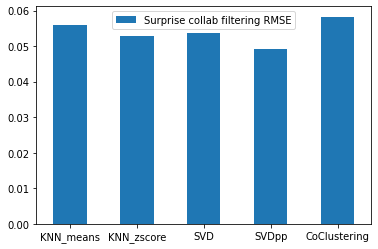

In [11]:
import matplotlib.pyplot as plt
res=[gs_KNN_M.best_score["rmse"],gs_KNN_Z.best_score["rmse"],gs_SVD.best_score["rmse"],\
     gs_SVDpp.best_score["rmse"],gs_CoClus.best_score["rmse"]]
res_df = pd.DataFrame(res, index =['KNN_means', 'KNN_zscore', 'SVD', 'SVDpp', 'CoClustering'],\
                      columns =['Surprise collab filtering RMSE'])
ax = res_df.plot.bar(rot=0)

### Evaluation par Recall@k

In [223]:
import random

class ModelEvaluator:
    def __init__(self,data_map,data_map_train,data_map_test,items_df):
        '''constructeur'''
        self.full_user_interact=data_map
        self.train_user_interact=data_map_train
        self.test_user_interact=data_map_test
        self.full_items=items_df

    def get_random_sample(self, uid, sample_size=100, seed=42):
        '''recup d'un set aléatoire d'articles non interagis dans le jeu données complet time cutté
            de taille sample_size
            pour l'utilisateur uid'''
        #on recupere le set non vu par l'utilisateur dans le jeu de données complet time cutté 
        non_clicked_items = set(self.full_items['article_id']) - set(self.full_user_interact.loc[self.full_user_interact["user_id"]==uid]['article_id'])
        #on tire un echantillon alétoire de ce set
        random.seed(seed)
        non_clicked_items_sample = set(random.sample(non_clicked_items, sample_size))
        return non_clicked_items_sample

    def _verify_hit_top_n(self, iid, recommended_items, topn):
        '''verfie si l'item iid est dans la liste de reco et si il est dans le top n des reco
            retourne un duo hit/index
            index = place dans la reco de l'iid / -1 pas dans la liste
            hit = 1 dans le topn 0 sinon'''
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == iid)
        except:
            index = -1
        #hit true false si dans le range passé en binaire 0/1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, uid):
        '''
        EVALUATION DU MODELE PAR UTILISATEUR
        
        renvoie le pourcentage d'iid clickés de top5/10 dans le test par un uid
        pour avoir ce pourcentage , sachant que le nombre d'iid clické peut etre <5 dans le test
        on le mix avec 100 iid non clickés alétoires considérés comme irrelevant
        '''

        #on recupere le SET des articles lus par le user / TEST
        uid_test_clicked_items = set(self.test_user_interact.article_id.loc[self.test_user_interact['user_id']==uid]) 
        #nombre d'articles lus par le user /TEST
        uid_test_nb_clicked_items = len(uid_test_clicked_items) 
        #on recupere la liste reco du modele pour l'uid' (fait dans l'algo de reco: en ignorant les interactions du train du user)
        #topn=0 veut dire qu'on sort la liste complete
        uid_reco = model.recommend_items(uid,topn=0)#, items_to_ignore=set(self.train_user_interact.loc[self.train_user_interact["user_id"]==uid]['article_id'])) #,topn=5)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #pour article lu par le user dans le TEST
        for iid in uid_test_clicked_items:
            #set de 100 articles aletoires non lus par le user avec seed constant par iid
            uid_non_clicked_items_sample = self.get_random_sample(uid, sample_size=100, seed=iid%(2**32))
            #on ajoute l'article courant avec le jeu aleatoire non lus
            uid_non_clicked_items_sample_u_test_clicked_iid = uid_non_clicked_items_sample.union(set([iid]))
            #filtrage de la reco de 1000 sur 100/101 aleatoire +iid
            
            
            
            filt_uid_reco = uid_reco.article_id.loc[uid_reco['article_id'].isin(uid_non_clicked_items_sample_u_test_clicked_iid)]
            #on verifie si l'article courant dans le top 5 / top 10 du 100 aleatoires et on incremente le hit count
            hit_at_5, index_at_5 = self._verify_hit_top_n(iid, filt_uid_reco.values, 5)
            
    #print(uid_reco.shape,filt_uid_reco.shape,uid,iid,hit_at_5, index_at_5)
            hits_at_5_count += hit_at_5
            
            hit_at_10, index_at_10 = self._verify_hit_top_n(iid, filt_uid_reco.values, 10)
            hits_at_10_count += hit_at_10

        #when mixed with a set of non-relevant items
        # pourcentage d'articles clickés dans le test dans le top 5/10 d'un sample mix de 100 items aléatoires considérés comme irrelevant à 100%
        uid_recall_at_5 = hits_at_5_count / float(uid_test_nb_clicked_items)
        uid_recall_at_10 = hits_at_10_count / float(uid_test_nb_clicked_items)

        uid_metrics = {'hits@5_count':hits_at_5_count, 
                        'hits@10_count':hits_at_10_count, 
                        'interacted_count': uid_test_nb_clicked_items,
                        'recall@5': uid_recall_at_5,
                        'recall@10': uid_recall_at_10}
        return uid_metrics

    def evaluate_model(self, model,breaknb):
        '''
        EVALUATION DU MODELE
            top5 global
            top10 global
        '''
        #calcul des stat pour chaque utilisateur du test ET PRESENT DANS LE TRAIN
        people_metrics = []
        random.seed(42)
        #on fait la liste d'uid : on utilise set pour sa propriete d'unicité et ensuite on repasse ne list pour pouvoir shuffuliser
        list_uid=list(set(self.test_user_interact.user_id.unique()).intersection(set(self.train_user_interact.user_id.unique())))
        random.shuffle(list_uid)
        for idx, uid in enumerate(list_uid):
            if idx % 100 == 0 and idx > 0:
                print('%d users processed' % idx, end='\r')
            person_metrics = self.evaluate_model_for_user(model, uid)  
            person_metrics['uid'] = uid
            people_metrics.append(person_metrics)
            print(idx, end='\r')
            ############
            if idx==breaknb:
                break
            ############
        print('%d users processed' % idx)

        results = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = results['hits@5_count'].sum() / float(results['interacted_count'].sum())
        global_recall_at_10 = results['hits@10_count'].sum() / float(results['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, results

In [217]:
import random
h={1,2,3,4,5,6,7,8,9}
hl=[1,2,3,4,5,6,7,8,9]
ht=(1,2,3,4,5,6,7,8,9)
hu=list(h)
random.seed(42)
random.shuffle(hu)
print(hu)

[4, 7, 8, 5, 9, 3, 6, 1, 2]


### content based

In [247]:
import numpy as np
from sklearn import preprocessing
import scipy
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    '''le fit calcule les users profiles'''
    
    MODEL_NAME = 'Content-Based'
    

    def __init__(self,data_map,i2vec,dic_ri,dic_ir):
        '''constructeur'''
        #dico inner raw iid
        self.dic_ir = dic_ir
        #dico raw inner iid
        self.dic_ri = dic_ri
        self.items_embedding = i2vec
        #les train interactions servent à:
            #calculer les profils
            #ignorer les interactions dans la reco
        self.train_user_interact = data_map
        
    ###############################################################
    #profilage des users avec le fit
        
    def _build_users_profile(self,uid, click_df,emb_matrix,dic_ri):
        '''calcul du profil embedding pour un uid
        à partir des interactions du train'''
        #on recupere le dataframe d'interaction pour l'uid ciblé
        click_uid_df = click_df.loc[click_df.user_id==uid]
        #on recupere les embeddings des items vus par l'uid
        user_item_profiles = np.array([emb_matrix[dic_ri[iid]] for iid in click_uid_df['article_id']])
        #on recupere le nombre de click sur les articles par l'uid afin d apporter une ponderation à la moyenne des embedding pour le calcul du profil
        user_item_strengths = np.array(click_uid_df['nb']).reshape(-1,1) #-1 veut dire unknow dim
        #on pondere la localisation embedding de chaque item par le nombre d'interactions puis on somme afin d'obtenir le profile qui est un barycentre
        user_item_strengths_weighted_avg = np.sum(np.multiply(user_item_profiles,user_item_strengths), axis=0) / np.sum(user_item_strengths)
        user_profile_norm = preprocessing.normalize(np.reshape(user_item_strengths_weighted_avg,(1,250)))
        return user_profile_norm

    def _build_users_profiles(self,click_df, emb_matrix,dic_ri): 
        '''calcul des profils de tous les uid sous forme de dic {uid:profil}
        à partir des interactions du train'''
        user_profiles = {}
        for uid in click_df.user_id.unique():
            user_profiles[uid] = self._build_users_profile(uid, click_df, emb_matrix, dic_ri)
        return user_profiles
    
    def fit(self):
        '''calcul des profils utilisateurs'''
        self.user_profiles=self._build_users_profiles(self.train_user_interact,self.items_embedding,self.dic_ri)
        #return self.user_profiles
        
    ###############################################################
    
    
    def get_model_name(self):
        '''renvoie le nom du modèle'''
        return self.MODEL_NAME
    

    def _get_similar_items_to_user_profile(self, uid):#, topn=100000):
        '''renvoie une liste d items similaires au profil de l'uid
            liste de couples (raw iid, cosine) triés par cosine decroissant'''
        #on calcul distances profil uid vs articles : sous forme 2D 1 ligne / nombre iid colonnes dans l'ordre inner du wemb
        cosine_similarities = cosine_similarity(self.user_profiles[uid], self.items_embedding)
        #on tri par distance: argsort donne les indices par scores croissants /flatten pour passer en 1D
        #on recupère un array des inner_iid de taille topn : les plus proches du profil sont à droite
        similar_indices = cosine_similarities.argsort().flatten()#[-topn:]
                                                        ################################################################################
        #on tri : sorted(iterable, key=None, reverse=False)
        # l'iterable est une liste de couples (raw_iid, cosine similarites)
        #on tri par similarité décroissante
        similar_items = [(self.dic_ir[i], cosine_similarities[0,i]) for i in similar_indices[::-1]]
        return similar_items
    
    #methode qui recommande en ignorant les articles deja vus
    def recommend_items(self, uid, topn=5):
        '''renvoie une liste de reco similaires au profil de l uid
            triés par cosine decroissant
             sans les interactions du train
                sous forme de dataframe'''
        #on recupere la liste brute de 1200 reco classés par cosine decroissant
        similar_items = self._get_similar_items_to_user_profile(uid)
        #on recupere la liste des iid a ignorer car deja vus
        #items_to_ignore = self.train_user_interact.loc[self.train_user_interact.user_id==uid,"article_id"].tolist()
        items_to_ignore = set(self.train_user_interact.loc[self.train_user_interact.user_id==uid].article_id)
        #on enleve les deja vus
        #similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        recommendations_df = pd.DataFrame(similar_items, columns=['article_id', 'cb_cosine_with_profile'])
        reco = recommendations_df.loc[recommendations_df.article_id.isin(items_to_ignore)==False].copy()
        if topn>0:
            reco=reco.head(topn)
        return reco

#### Collab Filtering

In [166]:
from surprise import Reader, Dataset,SVDpp
class CollabFiltRecommender:
    
    MODEL_NAME = 'Collaborative-Filtering-SVDpp'
    
    #constructeur
    def __init__(self,data_map):
        '''constructeur'''
        #les train interactions servent à:
            #calculer les profils
            #ignorer les interactions dans la reco
        self.train_user_interact = data_map
        
    #methode qui renvoie le nom du modele    
    def get_model_name(self):
        return self.MODEL_NAME
    
    #fit du modèle
    def fit(self):
        'fit du modele SVDpp'
        #constructeur du reader
        reader = Reader(rating_scale=(0,5))
        #lecture du train par surprise
        data = Dataset.load_from_df(self.train_user_interact[['user_id','article_id','nb']], reader)
        #costruction du trainset surprise 
        trainset = data.build_full_trainset()
        self.algo = SVDpp(n_epochs=20, lr_all=0.007, reg_all=0.1)
        self.algo.fit(trainset)

    
    def recommend_items(self,uid,topn=5):
        '''renvoie une liste de prediction pour un uid
            le SVD ne peut sortir des prédictions que pour les uid et iid dispo dans le train'''
        #prediction fonctionne avec les raws id
        #https://towardsdatascience.com/difference-between-apply-and-transform-in-pandas-242e5cf32705
        iid_to_ignore=set(self.train_user_interact.loc[self.train_user_interact.user_id==uid].article_id)
        items2pred=pd.DataFrame(set(self.train_user_interact.article_id)-iid_to_ignore,columns=['article_id'])
        items2pred['pred']=items2pred['article_id'].apply(lambda x:self.algo.predict(uid=uid, iid=x)[3])
        #pred['detail']=pred['article_id'].apply(lambda x:cf.predict(uid=uid, iid=x)[4])
        if topn==0:
            recommendations_df=items2pred.loc[:,['article_id','pred']].sort_values(by='pred', ascending=False)
        else:
            recommendations_df=items2pred.loc[:,['article_id','pred']].sort_values(by='pred', ascending=False).head(topn)

        return recommendations_df

#### Popularity Filtering

In [54]:
class PopularityFiltRecommender:
    
    MODEL_NAME = 'Popularity-Filtering'
    
    #constructeur
    def __init__(self,data_map):
        '''constructeur'''
        self.train_user_interact = data_map
        
    #methode qui renvoie le nom du modele    
    def get_model_name(self):
        return self.MODEL_NAME
    
    #fit du modèle
    def fit(self):
        self.raw_reco=self.train_user_interact[['nb','article_id']].groupby(['article_id']).sum().sort_values(by=['nb'],ascending=False).reset_index()

    def recommend_items(self,uid,topn=5):
        '''renvoie une liste de prediction pour un uid'''
        if topn==0:
            recommendations_df=self.raw_reco
        else:
            recommendations_df=self.raw_reco.head(topn)
        return recommendations_df

#### Hybrid Filtering

In [288]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid-Filtering'
    
    #constructeur
    def __init__(self,data_map,i2vec,dic_ri,dic_ir):
        '''constructeur'''
        self.train_user_interact = data_map
        self.dic_ir = dic_ir
        self.dic_ri = dic_ri
        self.items_embedding = i2vec
    
    def get_model_name(self):
        return self.MODEL_NAME
    
    #fit du modèle
    def fit(self):
        '''le fit consiste a fitter les sous modèles'''
        self.cf_model = CollabFiltRecommender(self.train_user_interact)
        self.cf_model.fit()
        self.cb_model = ContentBasedRecommender(self.train_user_interact,self.items_embedding,self.dic_ri,self.dic_ir)
        self.cb_model.fit()
        self.pf_model = PopularityFiltRecommender(self.train_user_interact)
        self.pf_model.fit()
        
    def recommend_items(self,uid,topn=5):
        '''renvoie une liste de prediction pour un uid'''
        #si uid pas connu du train: seul le popularity recommander fonctionne dans notre cas
        #on pourrait également concevoir un social reco basé sur un social profil, encore faudrait il avoir assez d 'infos'
        if uid not in set(self.train_user_interact.user_id):
            #parfait quand l'uid n'est pas connu du train, n a pas  d'interactions
            reco=self.pf_model.recommend_items(uid,0)
        else:
                # content based : permet de donner des iid qui n'ont pas d'interactions mais qui étaient disponibles
            reco_cb=self.cb_model.recommend_items(uid,0)
                # pour la normalisation, le but est de garder les meilleurs, donc les outliers positifs
                #il vaut mieux dans ce cas diviser par le max que par une standard deviation 
                #qui ne rendra pas forcement les outliers similaires entre facteurs pour une pondéaration
            #reco_cb['norm_cb']=(reco_cb.cb_cosine_with_profile-reco_cb.cb_cosine_with_profile.median())/(reco_cb.cb_cosine_with_profile.max()-reco_cb.cb_cosine_with_profile.median())
            reco_cb['rank_cb']=reco_cb.cb_cosine_with_profile.rank(ascending=False)
                # donne de bons resultats mais necessite des uid et des iid qui ont des interactions dans le train
            reco_cf=self.cf_model.recommend_items(uid,0)
            #reco_cf['norm_cf']=(reco_cf.pred-reco_cf.pred.median())/(reco_cf.pred.max()-reco_cf.pred.median())
            reco_cf['rank_cf']=reco_cf.pred.rank(ascending=False)
                #comment les pondérer? 80/20 normalisé par exemple?
                #en gros la pondération est anecdotique: on privilegie CF et quand on a pas de CF, on met la note de CB
            reco = reco_cb.merge(reco_cf,how='outer', on='article_id')
                #on fill les norm_cf vides (iid inconnu du train) par norm_cv avant pondération
                #on pourait également filler les iid peu interagis afin de favoriser le content dans ce cas la
            reco.loc[reco['rank_cf'].isnull(),'rank_cf'] = reco['rank_cb']
            reco['rank']=0.99999*reco['rank_cf']+0.00001*reco['rank_cb']
            
            reco=reco.sort_values(by='rank', ascending=True)


        if topn==0:
            recommendations_df=reco
        else:
            recommendations_df=reco.head(topn)
            
        return recommendations_df.reset_index(drop=True)
        #return recommendations_df

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

data_map,items_df, i2vec, dic_ir, dic_ri=cut_data_by_qtime(qtime=0.3)

data_map_sh=shuffle(data_map,random_state=42)
train, test = train_test_split(data_map_sh[['user_id','article_id','nb']],test_size=0.20,shuffle=False)#random_state=42)#,

In [231]:
pf_model = PopularityFiltRecommender(train)
pf_model.fit()
#cf_model.recommend_items(3)

In [234]:
model_evaluator = ModelEvaluator(data_map_sh,train,test,items_df)
global_metrics,results = model_evaluator.evaluate_model(model=pf_model,breaknb=2000)

2000 users processed


In [235]:
global_metrics

{'modelName': 'Popularity-Filtering',
 'recall@5': 0.9874357509994289,
 'recall@10': 0.989149057681325}

In [248]:
cb_model = ContentBasedRecommender(train,i2vec,dic_ri,dic_ir)
cb_model.fit()
#cb_model.recommend_items(uid=3,topn=1000)

In [249]:
model_evaluator = ModelEvaluator(data_map_sh,train,test,items_df)
global_metrics,results = model_evaluator.evaluate_model(model=cb_model,breaknb=200)

200 users processed


In [230]:
global_metrics

{'modelName': 'Content-Based',
 'recall@5': 0.29878048780487804,
 'recall@10': 0.40853658536585363}

In [236]:
cf_model = CollabFiltRecommender(train)
cf_model.fit()
#cf_model.recommend_items(3)

In [239]:
model_evaluator = ModelEvaluator(data_map_sh,train,test,items_df)
global_metrics,results = model_evaluator.evaluate_model(model=cf_model,breaknb=2000)

2000 users processed


In [240]:
global_metrics

{'modelName': 'Collaborative-Filtering-SVDpp',
 'recall@5': 0.7944031981724728,
 'recall@10': 0.9868646487721302}

In [289]:
hr_model = HybridRecommender(train,i2vec,dic_ri,dic_ir)
hr_model.fit()
#cb_model.recommend_items(uid=3,topn=1000)

In [291]:
model_evaluator = ModelEvaluator(data_map_sh,train,test,items_df)
global_metrics,results = model_evaluator.evaluate_model(model=hr_model,breaknb=200)

200 users processed


In [292]:
global_metrics

{'modelName': 'Hybrid-Filtering',
 'recall@5': 0.2804878048780488,
 'recall@10': 0.8902439024390244}

In [290]:
hz=hr_model.recommend_items(uid=5,topn=0)
display(hz.head(100))
display(hz.loc[hz.pred.isnull()==False].head(100))#.sort_values(by="norm_cf"))

,article_id,cb_cosine_with_profile,rank_cb,pred,rank_cf,rank
0,286255,0.826176,1.0,NaN,1.0,1.00000
1,68851,0.572613,18779.0,2.091679,1.0,1.18778
2,285728,0.820202,2.0,NaN,2.0,2.00000
3,237071,0.465695,53805.0,2.001314,2.0,2.53803
4,284145,0.820047,3.0,NaN,3.0,3.00000
...,...,...,...,...,...,...
95,313316,0.359395,107765.0,1.211659,49.0,50.07716
96,338553,0.583444,16338.0,1.210435,50.0,50.16288
97,284588,0.789854,51.0,NaN,51.0,51.00000
98,214341,0.611811,11001.0,1.209992,51.0,51.10950


,article_id,cb_cosine_with_profile,rank_cb,pred,rank_cf,rank
1,68851,0.572613,18779.0,2.091679,1.0,1.18778
3,237071,0.465695,53805.0,2.001314,2.0,2.53803
6,43032,0.340698,118564.0,1.874616,3.0,4.18561
8,38823,0.296158,145375.0,1.821510,4.0,5.45371
9,313513,0.401510,84659.0,1.545973,5.0,5.84654
...,...,...,...,...,...,...
185,65567,0.542987,26488.0,1.184170,97.0,97.26391
187,142279,0.110403,231804.0,1.184377,96.0,98.31708
189,264904,0.199357,199206.0,1.182505,98.0,99.99108
192,248489,0.181253,207557.0,1.181773,99.0,101.07458
